In [2]:
import sys
import json
import pickle
import warnings
import os.path as op
import numpy as np
import pandas as pd
from os import sep
import itertools as it
from copy import deepcopy
from utilities import files
from functools import partial
from tqdm import trange, tqdm
import matplotlib.pylab as plt
from matplotlib import ticker
from joblib import Parallel, delayed
from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler
from mne import read_epochs, pick_channels
from sklearn.neighbors import KernelDensity
import statsmodels.api as sm
from scipy.stats import gaussian_kde
from extra.tools import many_is_in, cat, shuffle_array, shuffle_array_range, consecutive_margin_ix, dump_the_dict

In [3]:
sensors = [
    'MLC21', 'MLC22', 'MLC23', 'MLC24', 
    'MLC31', 'MLC41', 'MLC51', 'MLC52', 
    'MLC53', 'MLC61', 'MLC62'
]

columns = [
    'trial',
    'peak_freq',
    'peak_amp_iter',
    'peak_amp_base',
    'peak_time',
    'peak_adjustment',
    'fwhm_freq',
    'fwhm_time',
    'polarity',
    'block',
    'pp_ix',
    'subject',
    'sensor',
    'trial_type'
]

In [4]:
path = "/home/mszul/datasets/explicit_implicit_beta/derivatives/processed"
subs = files.get_folders_files(path)[0]
subs = [op.join(i, "MU_bursts") for i in subs]
subs = [i for i in subs if op.exists(i)]
subs.sort()

json_files = {}
for sub in subs:
    sub_id = sub.split(sep)[-2]
    subs_bursts = files.get_files(sub, "", ".json")[2]
    subs_bursts = [i for i in subs_bursts if many_is_in(sensors, i)]
    subs_bursts.sort()
    json_files[sub_id] = subs_bursts

all_files = [y for i in json_files.keys() for y in json_files[i]]

In [5]:
MU_features = "/home/mszul/datasets/explicit_implicit_beta/derivatives/PCA_results/MU_features.csv"
MU_waveforms = "/home/mszul/datasets/explicit_implicit_beta/derivatives/PCA_results/MU_waveforms.npy"

if all([op.exists(MU_features), op.exists(MU_waveforms)]):
    waveforms = np.load(MU_waveforms)
    columns_dict = pd.read_csv(MU_features)
else:
    waveforms = []
    columns_dict = {i: [] for i in columns}
    for f in tqdm(all_files):
        with open(f) as pipeline_file:
            data_single = json.load(pipeline_file)
        info = np.array(f.split(sep)[-1].split("-"))
        sensor = info[1]
        subject = "-".join(info[2:4])
        trial_type = info[4]
        shape = np.array(data_single["pp_ix"]).shape[0]
        for c in columns:
            if c == "sensor":
                columns_dict["sensor"].extend(np.tile(sensor, shape).tolist())
                pass
            elif c == "trial_type":
                columns_dict["trial_type"].extend(np.tile(trial_type, shape).tolist())
            elif c == "subject":
                columns_dict["subject"].extend(np.tile(subject, shape).tolist())
            else:
                columns_dict[c].extend(data_single[c])
        waveforms.append(np.array(data_single["waveform"]))

    columns_dict = pd.DataFrame.from_dict(columns_dict)
    columns_dict.to_csv(MU_features, index=False)
    waveforms = np.vstack(waveforms)
    np.save(MU_waveforms, waveforms)

In [5]:
mean_wvf = np.mean(waveforms, axis=0)

In [6]:
def signaltonoise(a, axis=0, ddof=0):
    a = np.asanyarray(a)
    m = a.mean(axis)
    sd = a.std(axis=axis, ddof=ddof)
    return np.where(sd == 0, 0, m/sd)

SNR = signaltonoise(waveforms, axis=0, ddof=1)

In [7]:
times = np.linspace(-270/600, 270/600, num=540)

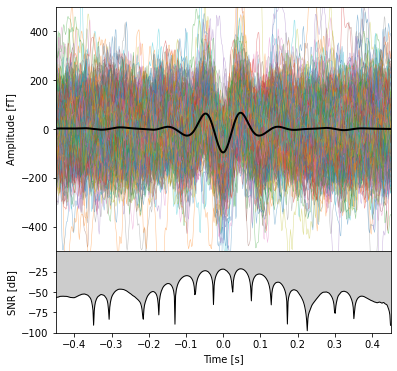

In [8]:
fig = plt.figure(figsize=(6, 6), constrained_layout=False)
grid = fig.add_gridspec(2,1, wspace=0, hspace=0, height_ratios=(4.5, 1.5))
xx0 = grid[0, 0].subgridspec(1,1)
ax0 = xx0.subplots()
ax0.set_xticks([])
ax0.plot(times, waveforms[::5000,:].T/1e-15, lw=0.5, alpha=0.5)
ax0.plot(times, mean_wvf/1e-15, lw=2, c="black")
ax0.set_ylim(-500, 500)
ax0.set_xlim(-270/600, 270/600)
ax0.set_ylabel("Amplitude [fT]")

xx1 = grid[1, 0].subgridspec(1,1)
ax1 = xx1.subplots()
ax1.fill_between(times, np.zeros(times.shape), 10*np.log10(SNR**2), lw=0, color="black", alpha=0.2)
ax1.plot(times, 10*np.log10(SNR**2), lw=1, color="black")
ax1.set_ylim(-100, 0)
ax1.set_xlim(-270/600, 270/600)
ax1.set_ylabel("SNR [dB]")
ax1.set_xlabel("Time [s]")
ax1.set_yticks([-25, -50, -75, -100])
plt.savefig("/home/mszul/datasets/explicit_implicit_beta/derivatives/PCA_results/images/MU_waveform.svg")

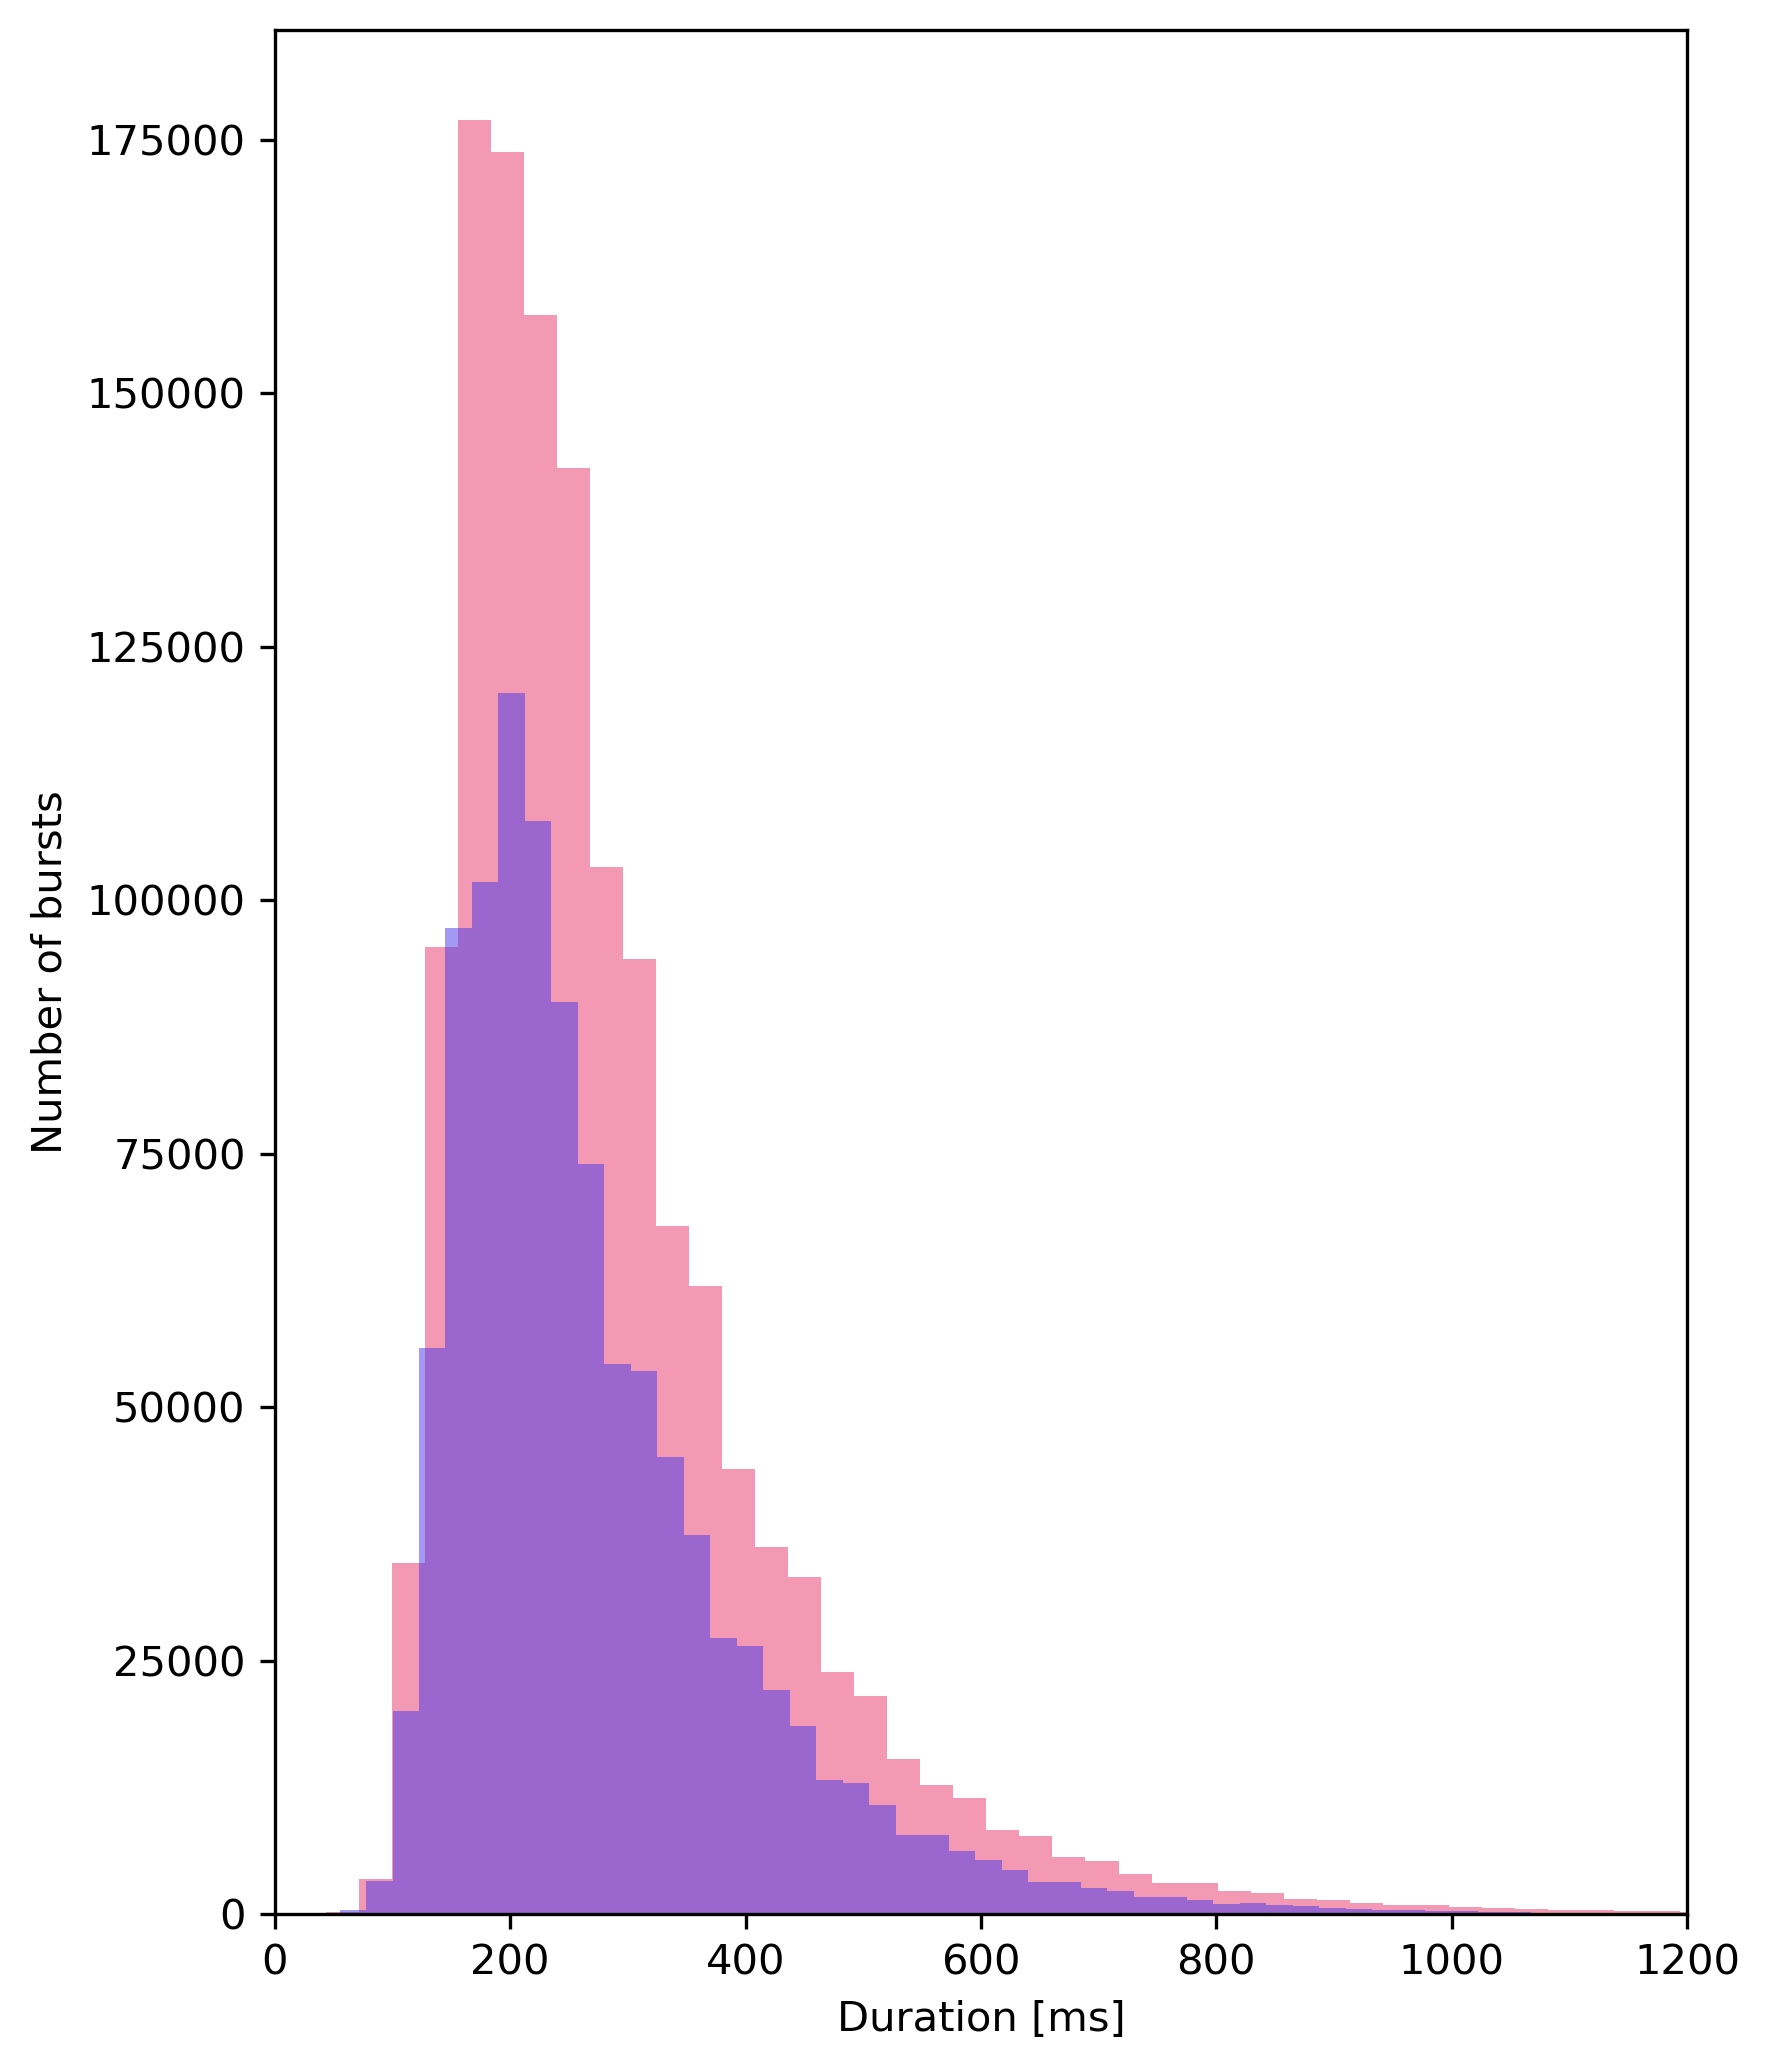

In [9]:
cw_m = "#4634eb"
cw_v = "#eb346b"

f, ax = plt.subplots(1, 1, figsize=(6, 7), dpi=300)
ax.hist(columns_dict.loc[columns_dict.trial_type == "visual"].fwhm_time.values*1e3, bins=100, alpha=0.5, color=cw_v);
ax.hist(columns_dict.loc[columns_dict.trial_type == "motor"].fwhm_time.values*1e3, bins=100, alpha=0.5, color=cw_m);
ax.set_xlim(0, 1200)
ax.set_ylabel("Number of bursts")
ax.set_xlabel("Duration [ms]")
plt.tight_layout()
plt.savefig("/home/mszul/datasets/explicit_implicit_beta/derivatives/PCA_results/images/MU_burst_duration_hist.svg")

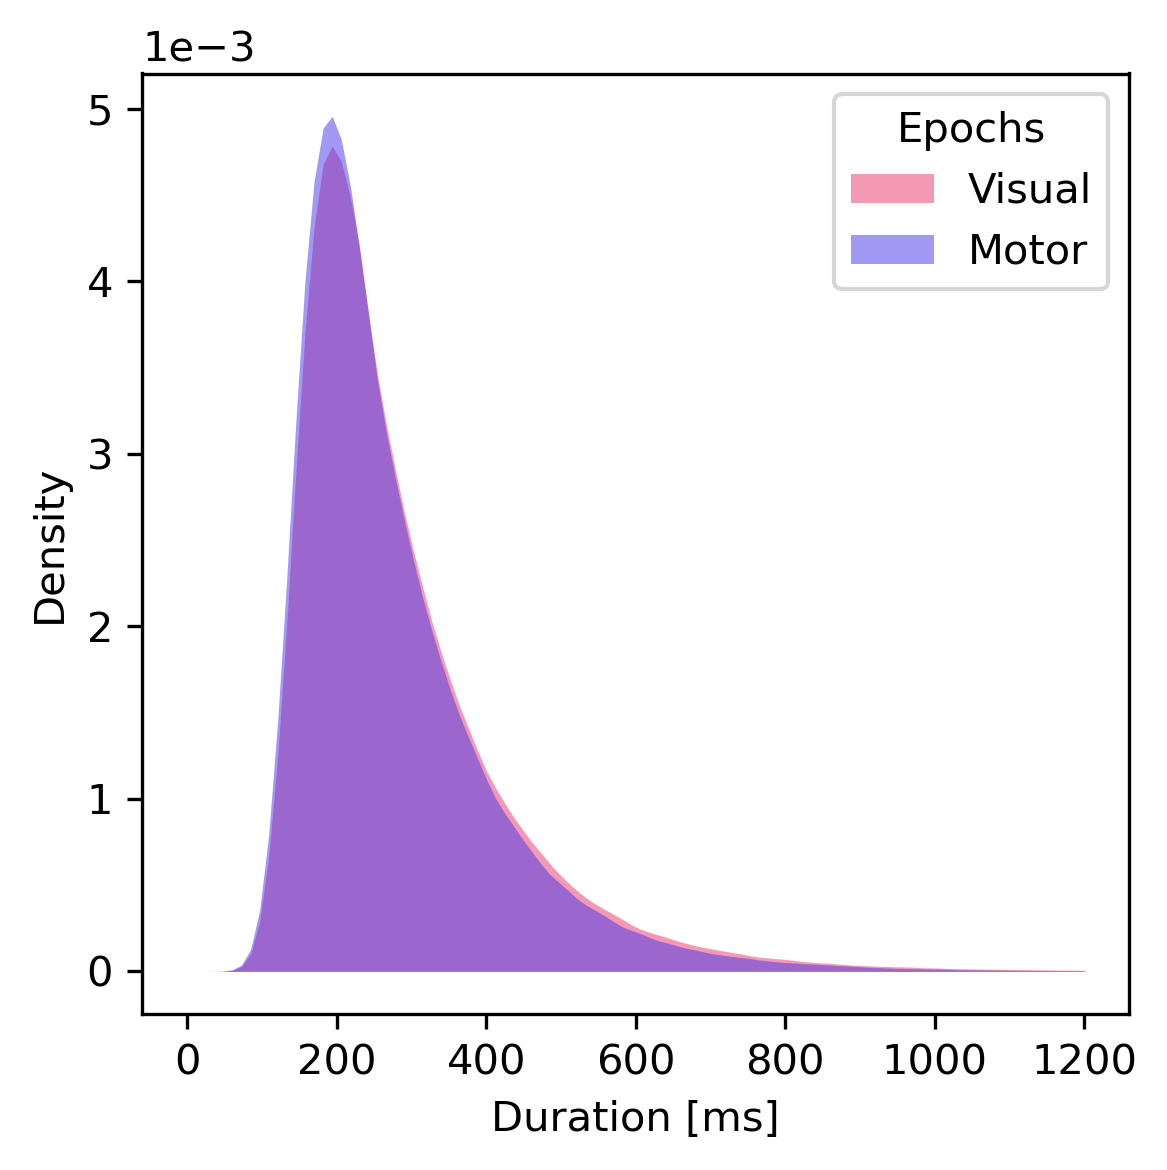

In [12]:
cw_m = "#4634eb"
cw_v = "#eb346b"

f, ax = plt.subplots(1, 1, figsize=(4, 4), dpi=300)

x = np.linspace(0, 1200, num=100)
kde_vis = gaussian_kde(columns_dict.loc[columns_dict.trial_type == "visual"].fwhm_time.values*1e3)
kde_mot = gaussian_kde(columns_dict.loc[columns_dict.trial_type == "motor"].fwhm_time.values*1e3)

ax.fill_between(x, 0, kde_vis(x), lw=0, color=cw_v, label="Visual", alpha=0.5)
ax.fill_between(x, 0, kde_mot(x), lw=0, color=cw_m, label="Motor", alpha=0.5)

ax.legend(title="Epochs")
ax.ticklabel_format(axis="y", style="sci", scilimits=(10, 3))
ax.set_ylabel("Density")
ax.set_xlabel("Duration [ms]")
plt.tight_layout()
plt.savefig("/home/mszul/datasets/explicit_implicit_beta/derivatives/PCA_results/images/MU_burst_duration_kde.svg")

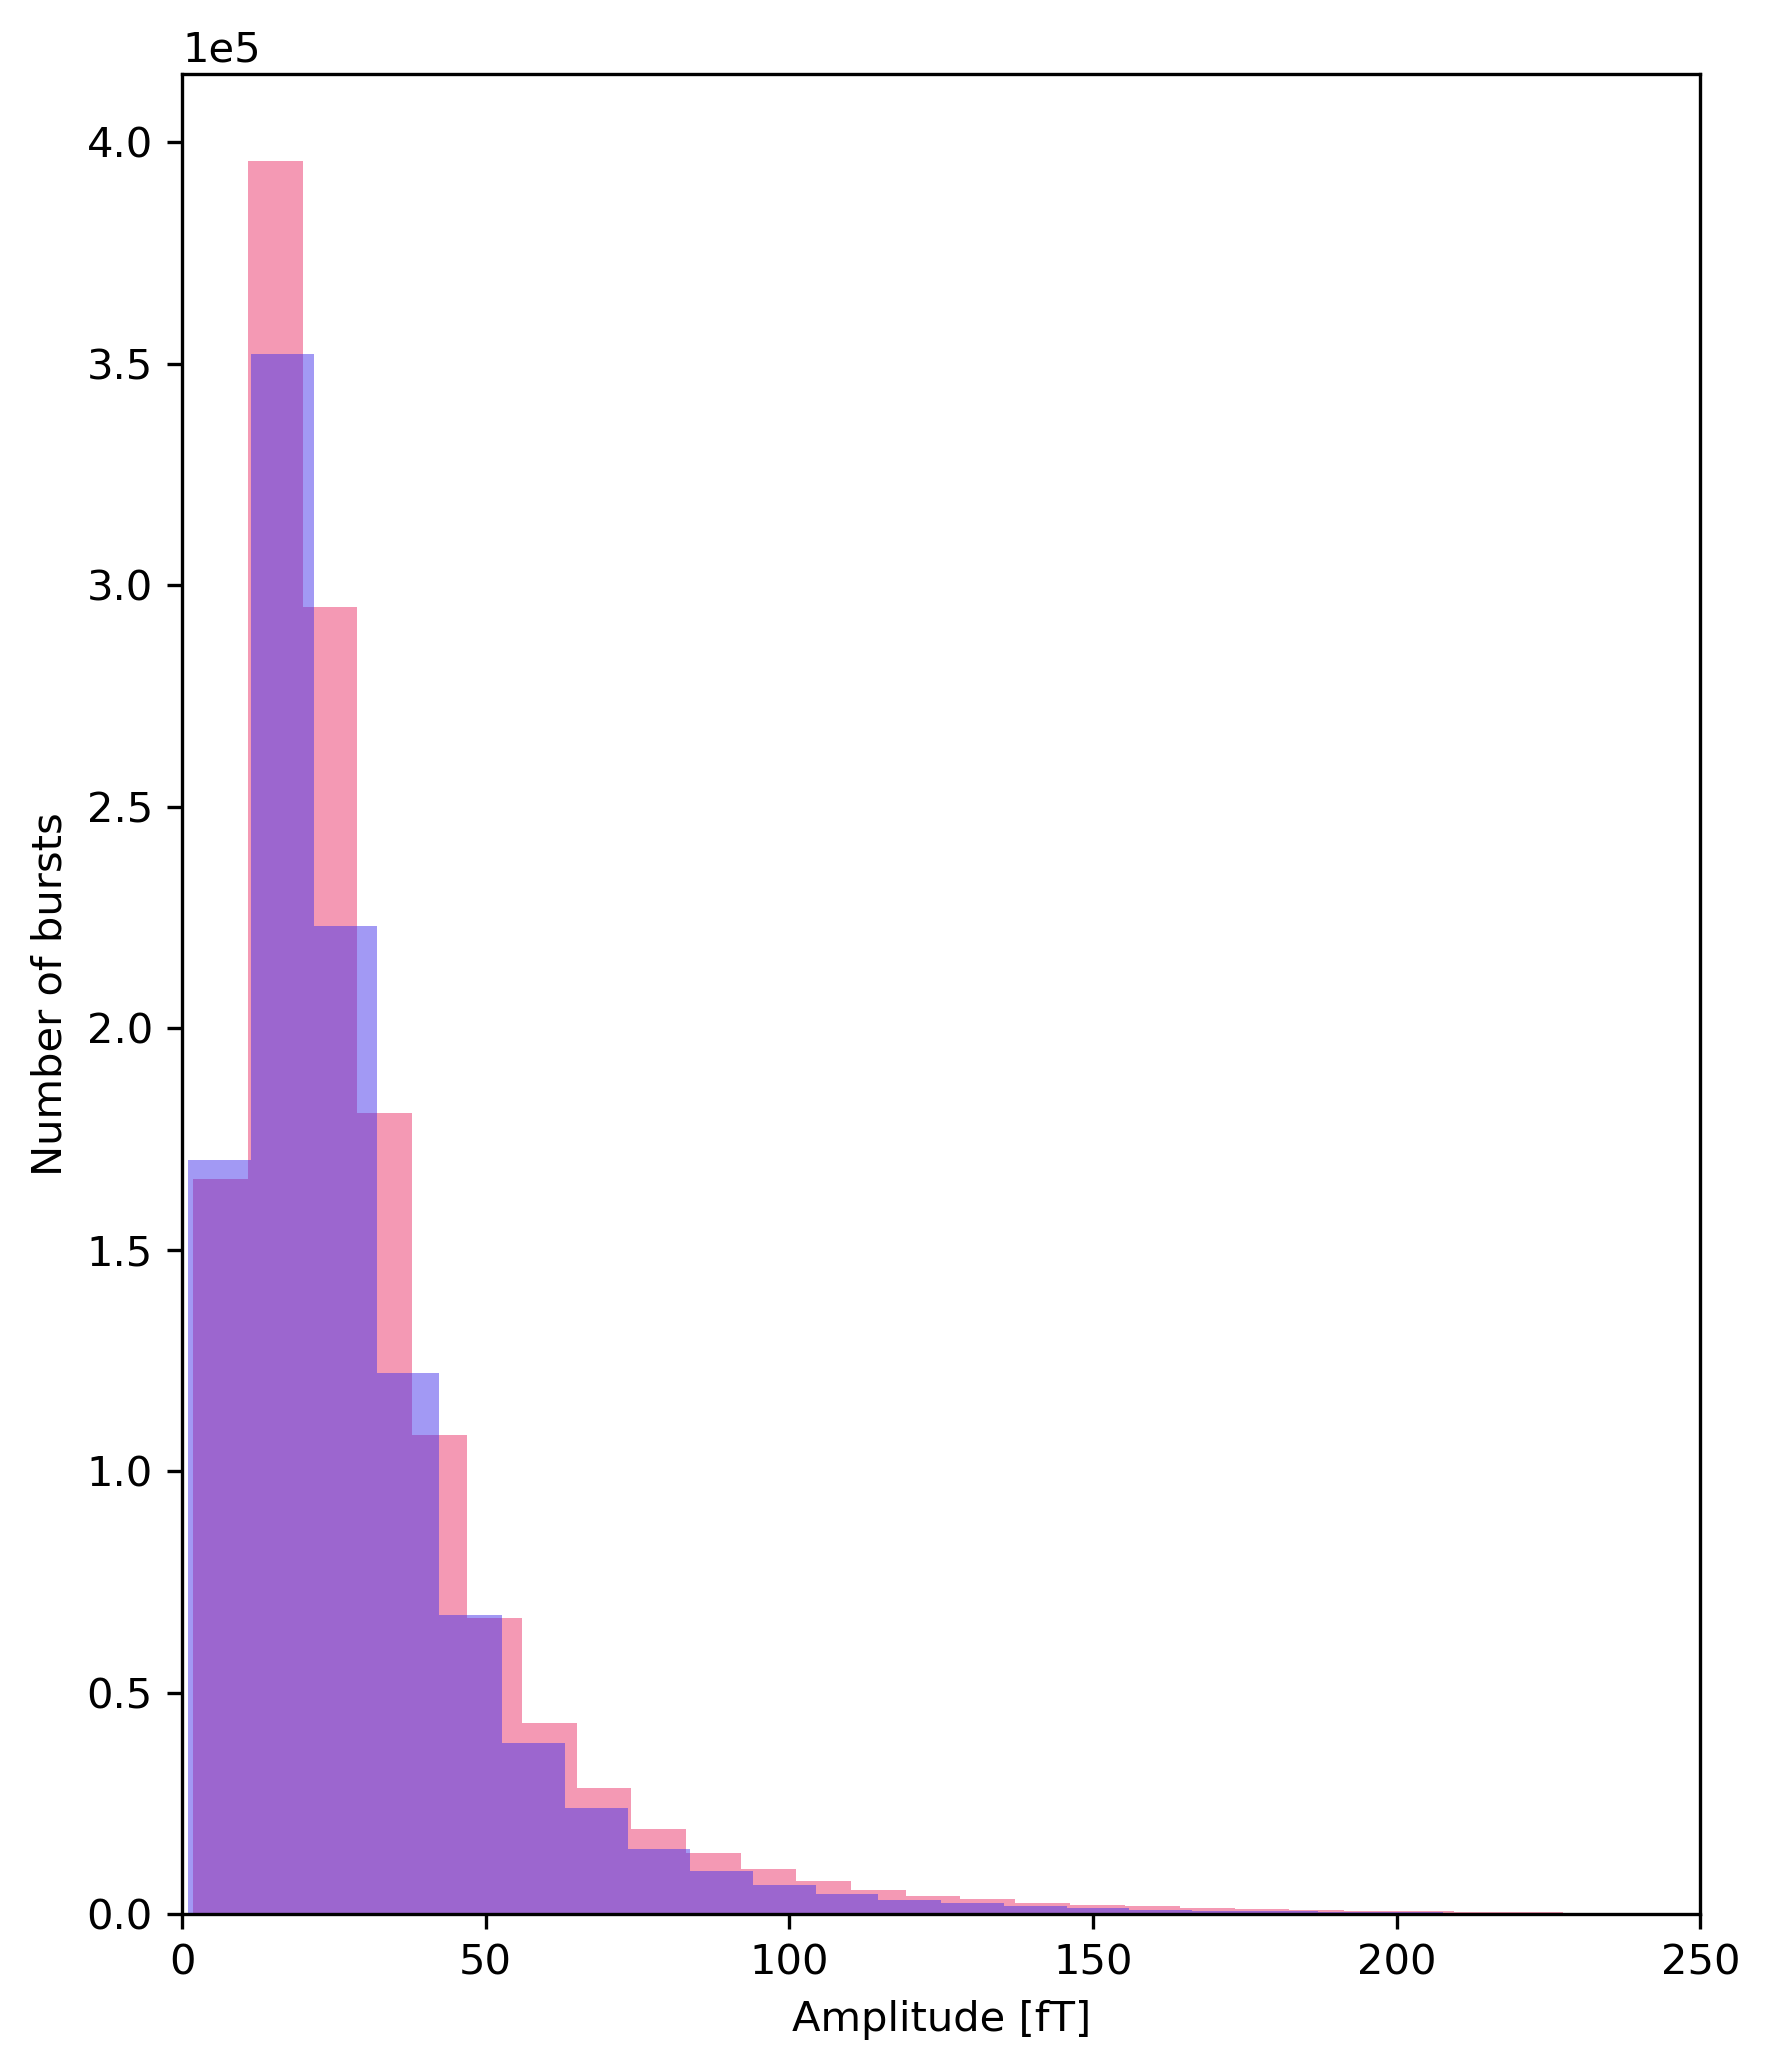

In [13]:
cw_m = "#4634eb"
cw_v = "#eb346b"

f, ax = plt.subplots(1, 1, figsize=(6, 7), dpi=300)
ax.hist(columns_dict.loc[columns_dict.trial_type == "visual"].peak_amp_base.values/1e-15, bins=2000, alpha=0.5, color=cw_v);
ax.hist(columns_dict.loc[columns_dict.trial_type == "motor"].peak_amp_base.values/1e-15, bins=2000, alpha=0.5, color=cw_m);
ax.set_ylabel("Number of bursts")
ax.set_xlabel("Amplitude [fT]")
ax.set_xlim(0, 250)
ax.ticklabel_format(axis="y", style="sci", scilimits=(10, 3))
plt.tight_layout()
plt.savefig("/home/mszul/datasets/explicit_implicit_beta/derivatives/PCA_results/images/MU_burst_amplitude_hist.svg")

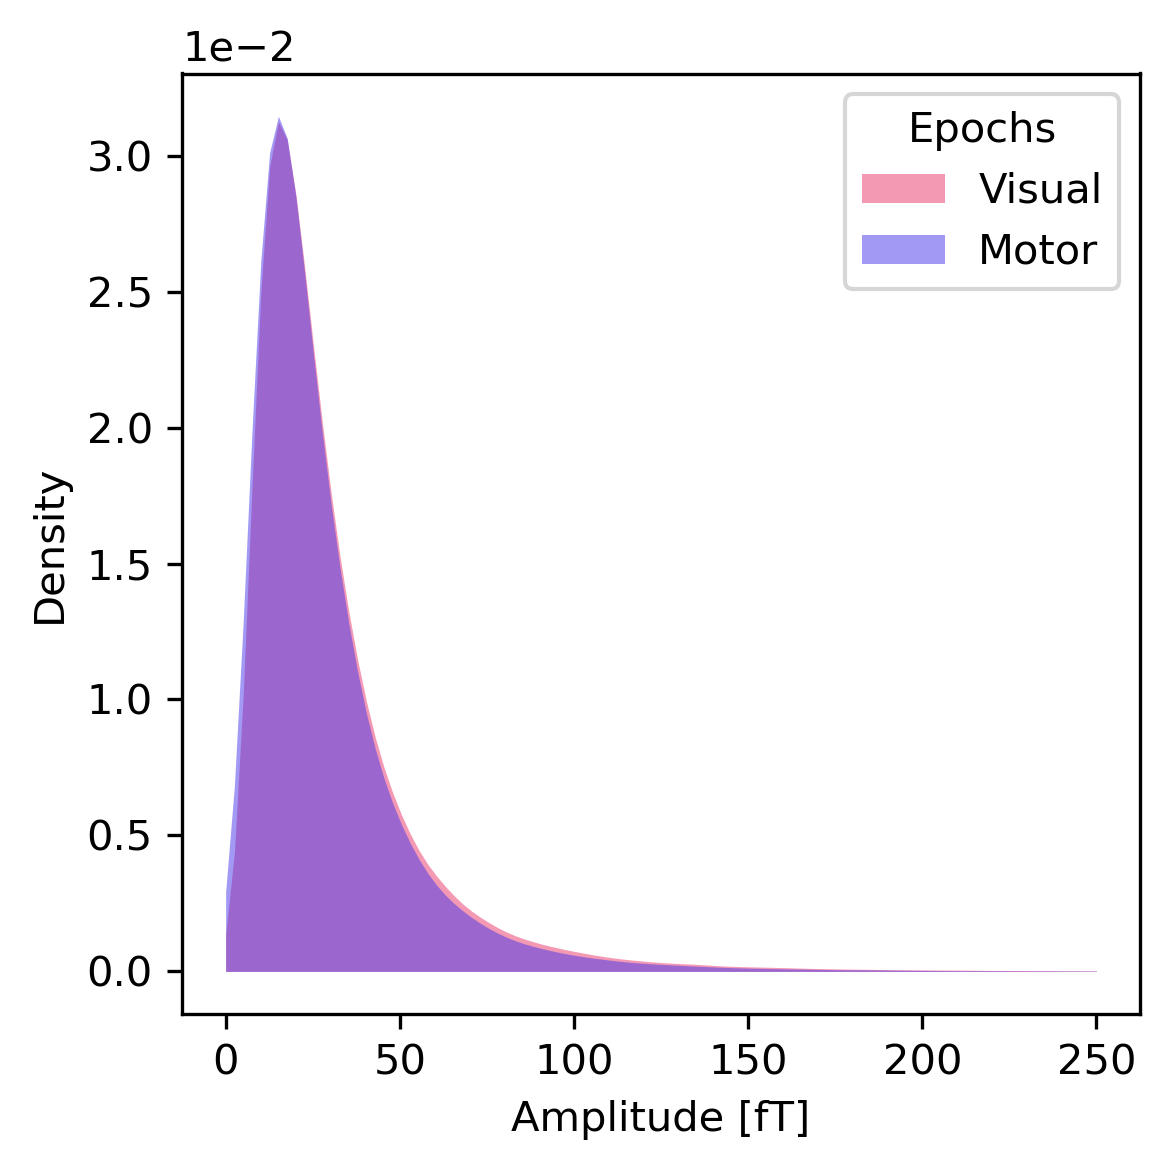

In [14]:
cw_m = "#4634eb"
cw_v = "#eb346b"

f, ax = plt.subplots(1, 1, figsize=(4, 4), dpi=300)

x = np.linspace(0, 250, num=100)
kde_vis = gaussian_kde(columns_dict.loc[columns_dict.trial_type == "visual"].peak_amp_base.values/1e-15)
kde_mot = gaussian_kde(columns_dict.loc[columns_dict.trial_type == "motor"].peak_amp_base.values/1e-15)

ax.fill_between(x, 0, kde_vis(x), lw=0, color=cw_v, label="Visual", alpha=0.5)
ax.fill_between(x, 0, kde_mot(x), lw=0, color=cw_m, label="Motor", alpha=0.5)

ax.legend(title="Epochs")
ax.ticklabel_format(axis="y", style="sci", scilimits=(10, 3))
ax.set_ylabel("Density")
ax.set_xlabel("Amplitude [fT]")
plt.tight_layout()
plt.savefig("/home/mszul/datasets/explicit_implicit_beta/derivatives/PCA_results/images/MU_burst_amplitude_kde.svg")

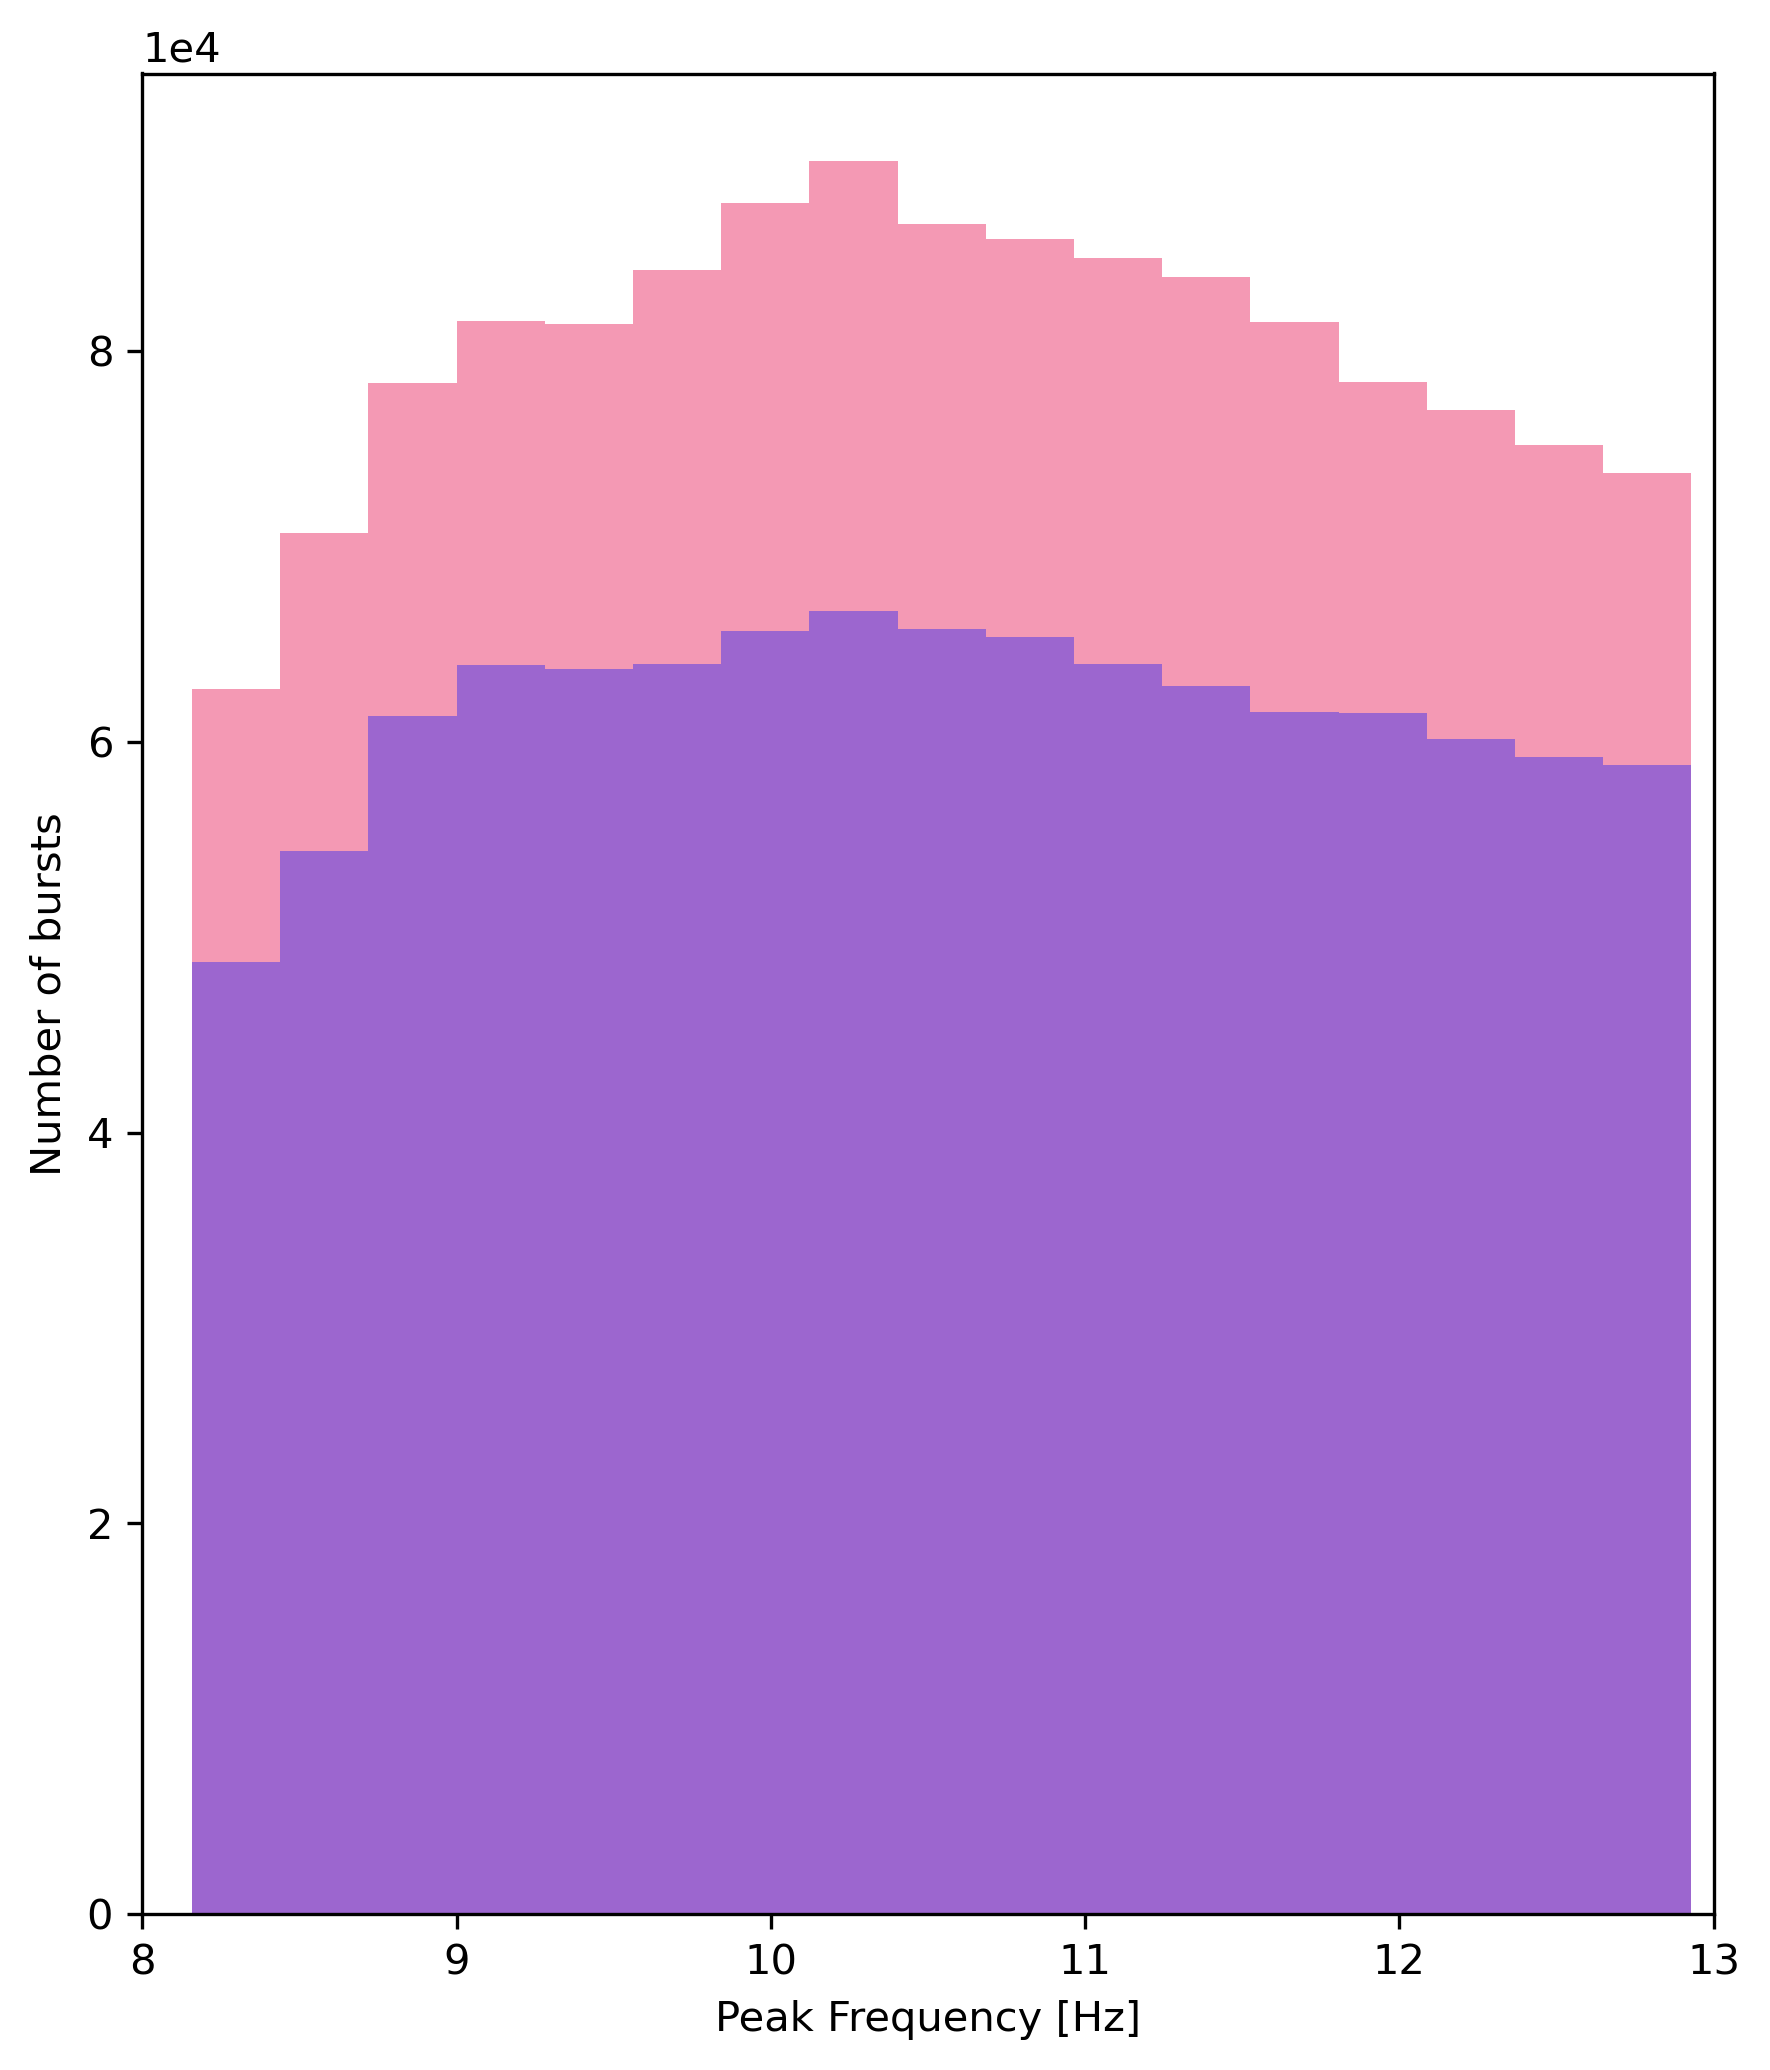

In [15]:
cw_m = "#4634eb"
cw_v = "#eb346b"

f, ax = plt.subplots(1, 1, figsize=(6, 7), dpi=300)
ax.hist(columns_dict.loc[columns_dict.trial_type == "visual"].peak_freq.values, bins=17, alpha=0.5, color=cw_v);
ax.hist(columns_dict.loc[columns_dict.trial_type == "motor"].peak_freq.values, bins=17, alpha=0.5, color=cw_m);
ax.set_xlim(8, 13)
ax.set_ylabel("Number of bursts")
ax.set_xlabel("Peak Frequency [Hz]")
ax.ticklabel_format(axis="y", style="sci", scilimits=(10, 3))
plt.tight_layout()
plt.savefig("/home/mszul/datasets/explicit_implicit_beta/derivatives/PCA_results/images/MU_burst_peak_frequency_hist.svg")

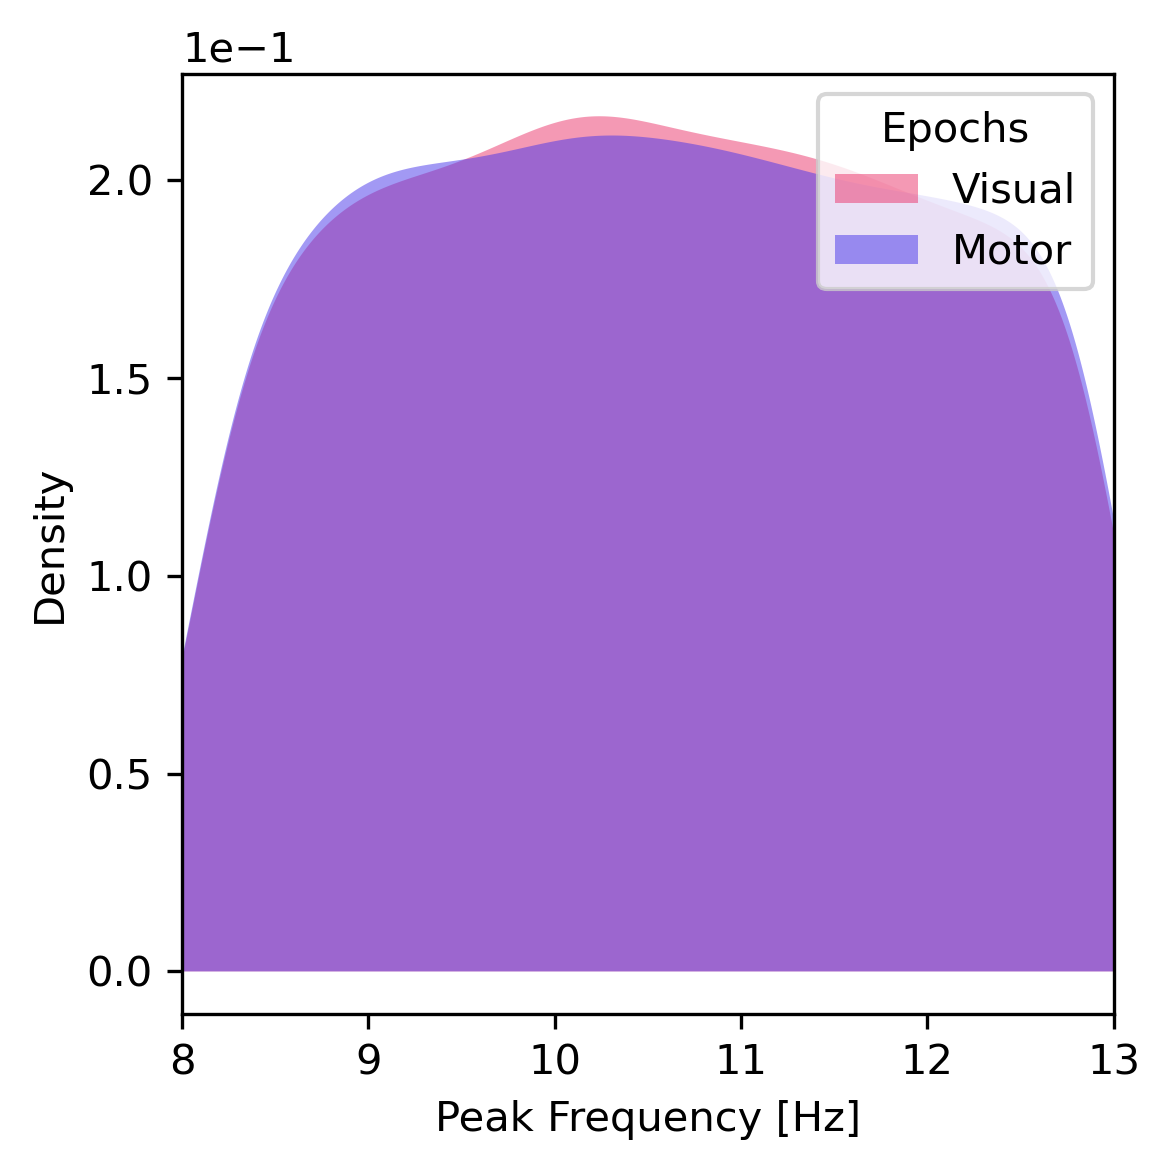

In [11]:
cw_m = "#4634eb"
cw_v = "#eb346b"

f, ax = plt.subplots(1, 1, figsize=(4, 4), dpi=300)

kde_vis = sm.nonparametric.KDEUnivariate(columns_dict.loc[columns_dict.trial_type == "visual"].peak_freq.values)
kde_vis.fit(bw=0.3)
kde_mot = sm.nonparametric.KDEUnivariate(columns_dict.loc[columns_dict.trial_type == "motor"].peak_freq.values)
kde_mot.fit(bw=0.3)

ax.fill_between(kde_vis.support, 0, kde_vis.density, lw=0, color=cw_v, label="Visual", alpha=0.5, rasterized=True)
ax.fill_between(kde_mot.support, 0, kde_mot.density, lw=0, color=cw_m, label="Motor", alpha=0.5, rasterized=True)
ax.set_xlim(8, 13)
ax.legend(title="Epochs")
ax.ticklabel_format(axis="y", style="sci", scilimits=(10, 3))
ax.set_ylabel("Density")
ax.set_xlabel("Peak Frequency [Hz]")
plt.tight_layout()
plt.savefig("/home/mszul/datasets/explicit_implicit_beta/derivatives/PCA_results/images/MU_burst_peak_frequency_kde.svg")

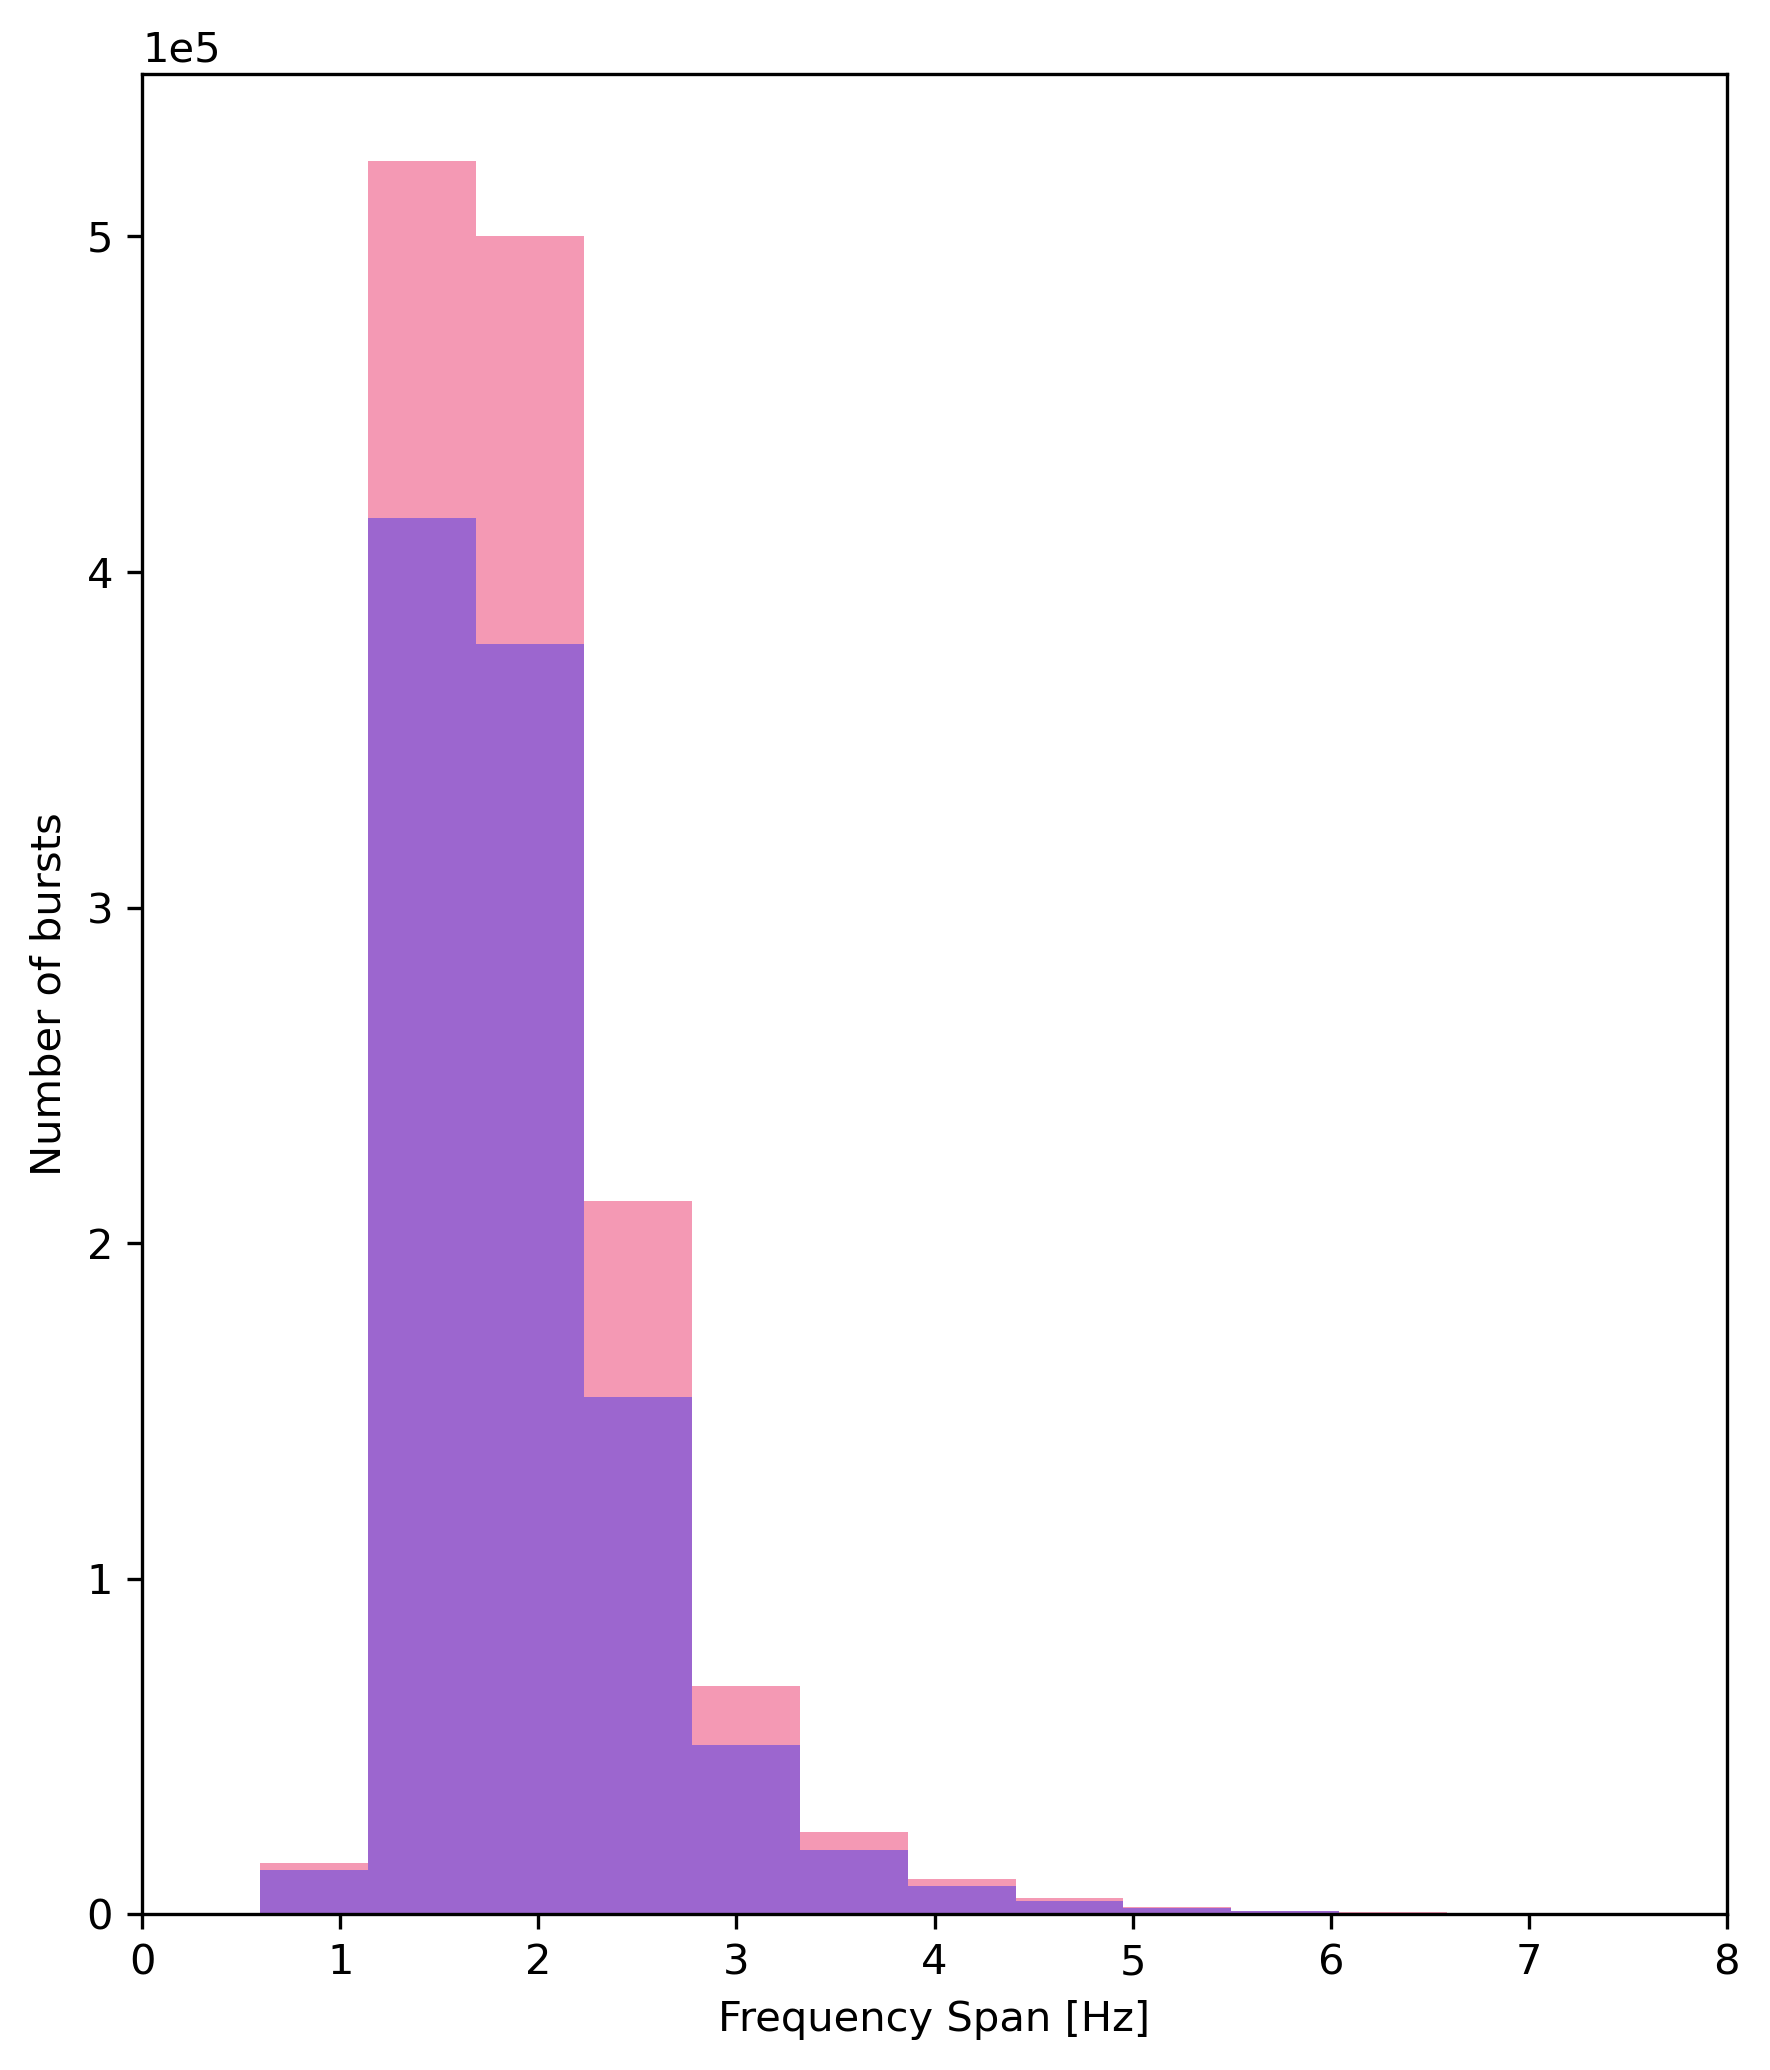

In [17]:
cw_m = "#4634eb"
cw_v = "#eb346b"

f, ax = plt.subplots(1, 1, figsize=(6, 7), dpi=300)
ax.hist(columns_dict.loc[columns_dict.trial_type == "visual"].fwhm_freq.values, bins=23, alpha=0.5, color=cw_v);
ax.hist(columns_dict.loc[columns_dict.trial_type == "motor"].fwhm_freq.values, bins=23, alpha=0.5, color=cw_m);
ax.set_xlim(0, 8)
ax.set_ylabel("Number of bursts")
ax.set_xlabel("Frequency Span [Hz]")
ax.ticklabel_format(axis="y", style="sci", scilimits=(10, 3))
plt.tight_layout()
plt.savefig("/home/mszul/datasets/explicit_implicit_beta/derivatives/PCA_results/images/MU_burst_freq_span_hist.svg")

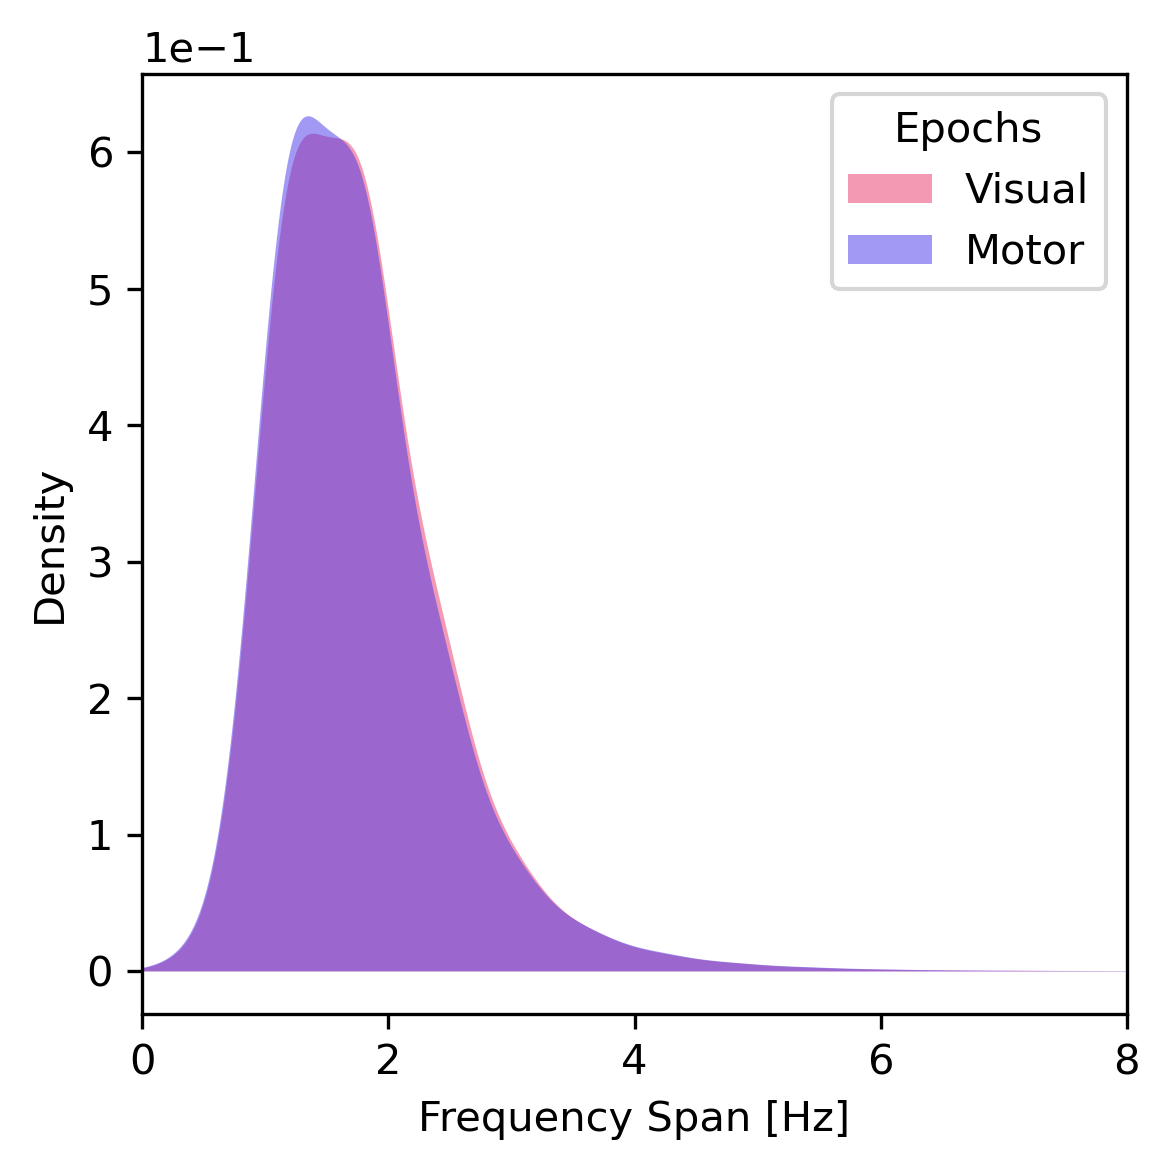

In [30]:
cw_m = "#4634eb"
cw_v = "#eb346b"

f, ax = plt.subplots(1, 1, figsize=(4, 4), dpi=300)


kde_vis = sm.nonparametric.KDEUnivariate(columns_dict.loc[columns_dict.trial_type == "visual"].fwhm_freq.values)
kde_vis.fit(bw=0.3)
kde_mot = sm.nonparametric.KDEUnivariate(columns_dict.loc[columns_dict.trial_type == "motor"].fwhm_freq.values)
kde_mot.fit(bw=0.3)

ax.fill_between(kde_vis.support, 0, kde_vis.density, lw=0, color=cw_v, label="Visual", alpha=0.5, rasterized=True)
ax.fill_between(kde_mot.support, 0, kde_mot.density, lw=0, color=cw_m, label="Motor", alpha=0.5, rasterized=True)

ax.legend(title="Epochs")
ax.ticklabel_format(axis="y", style="sci", scilimits=(10, 3))
ax.set_ylabel("Density")
ax.set_xlabel("Frequency Span [Hz]")
ax.set_xlim(0, 8)
plt.tight_layout()
plt.savefig("/home/mszul/datasets/explicit_implicit_beta/derivatives/PCA_results/images/MU_burst_freq_span_kde.svg")

In [ ]:
waveform_beta = np.load("/home/mszul/datasets/explicit_implicit_beta/derivatives/PCA_results/waveforms_clean_subset_fit.npy")
waveform_beta = np.mean(waveform_beta, axis=0)

In [ ]:
waveform_MU = np.mean(waveforms, axis=0)
beta_time = np.linspace(-130, 130, num=156)

In [ ]:
peak_freq = columns_dict.peak_freq.values

freqs = np.linspace(8, 13, num=6)
freq_ranges = list(zip(freqs[:-1], freqs[1:]))
f, ax = plt.subplots(1, 1, figsize=(7, 5), dpi=300)

col_r = plt.cm.winter(np.linspace(0,1, num=len(freq_ranges)))

offset = np.linspace(-75, 75, num=len(freq_ranges))

for f_ix, f in enumerate(freq_ranges):
    mwfv = np.mean(waveforms[(peak_freq>=f[0]) & (peak_freq<=f[1]),:], axis=0)
    label = "{}-{} Hz".format(*f)
    ax.plot(times, mwfv/1e-15 + offset[f_ix], lw=1, c=col_r[f_ix], label=label)
ax.plot(times, waveform_MU/1e-15, lw=1, c="black", label="Mean Mu Burst")
ax.legend(fontsize="small")
# ax.set_xlim(-270, 270)
# ax.set_ylim(-210, 210)
plt.savefig("/home/mszul/datasets/explicit_implicit_beta/derivatives/PCA_results/images/MU_burst_per_freq.svg")

In [ ]:
beta_features_path = "/home/mszul/datasets/explicit_implicit_beta/derivatives/PCA_results/burst_features_sensors.csv"
beta_waveforms_path = "/home/mszul/datasets/explicit_implicit_beta/derivatives/PCA_results/waveforms_sensors.npy"

beta_waveforms = np.load(beta_waveforms_path)
beta_features = pd.read_csv(beta_features_path)

In [ ]:
beta_time = np.linspace(-130, 130, num=156)/ 1000
beta_peak_freq = beta_features.peak_freq.values
beta_freqs = list(range(13, 31))
beta_freq_ranges = list(zip(beta_freqs[:-1], beta_freqs[1:]))
col_r = plt.cm.winter(np.linspace(0,1, num=len(beta_freq_ranges)))
offset = np.linspace(-120, 120, num=len(beta_freq_ranges))

f, ax = plt.subplots(1, 1, figsize=(7, 5), dpi=300)
for f_ix, f in enumerate(beta_freq_ranges):
    bwfv = np.mean(beta_waveforms[(beta_peak_freq>=f[0]) & (beta_peak_freq<=f[1]),:], axis=0)
    label = "{}-{} Hz".format(*f)
    ax.plot(beta_time, bwfv/1e-15 + offset[f_ix], lw=1, c=col_r[f_ix], label=label)
    
ax.plot(beta_time, waveform_beta/1e-15, lw=1, c="black", label="Mean Beta Burst")
ax.legend(fontsize="xx-small")
# ax.set_xlim(-270, 270)
# ax.set_ylim(-210, 210)
plt.savefig("/home/mszul/datasets/explicit_implicit_beta/derivatives/PCA_results/images/beta_burst_per_freq.svg")

In [ ]:
f, ax = plt.subplots(1,1, figsize=(14,8), facecolor="white")
ax.plot(times, waveform_MU/1e-15, lw=3, c="red", label="Mean Mu Burst")
ax.plot(beta_time, waveform_beta/1e-15, lw=3, c="green", label="Mean Beta Burst")
ax.legend(fontsize="small")
ax.set_xlim(beta_time[0], beta_time[-1])
plt.savefig("/home/mszul/datasets/explicit_implicit_beta/derivatives/PCA_results/images/beta_mu_burst_mean_zoom.svg")

In [ ]:
f, ax = plt.subplots(1,1, figsize=(14,8), facecolor="white")
ax.plot(times, waveform_MU/1e-15, lw=3, c="red", label="Mean Mu Burst")
ax.plot(beta_time, waveform_beta/1e-15, lw=3, c="green", label="Mean Beta Burst")
ax.legend(fontsize="small")
plt.savefig("/home/mszul/datasets/explicit_implicit_beta/derivatives/PCA_results/images/beta_mu_burst_mean.svg")

In [ ]:
peak_freq = columns_dict.peak_freq.values

freqs = np.linspace(8, 13, num=6)
freq_ranges = list(zip(freqs[:-1], freqs[1:]))
f, ax = plt.subplots(1, 1, figsize=(7, 5), dpi=300)

col_r = plt.cm.winter(np.linspace(0,1, num=len(freq_ranges)))

offset = np.linspace(-75, 75, num=len(freq_ranges))

for f_ix, f in enumerate(freq_ranges):
    mwfv = np.mean(waveforms[(peak_freq>=f[0]) & (peak_freq<=f[1]),:], axis=0)
    label = "{}-{} Hz".format(*f)
    ax.plot(times, mwfv/1e-15 + offset[f_ix], lw=1, c=col_r[f_ix], label=label)
ax.plot(times, waveform_MU/1e-15, lw=1, c="black", label="Mean Mu Burst")
ax.legend(fontsize="small")
ax.set_xlim(beta_time[0], beta_time[-1])
plt.savefig("/home/mszul/datasets/explicit_implicit_beta/derivatives/PCA_results/images/MU_burst_per_freq_zoom.svg")